# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


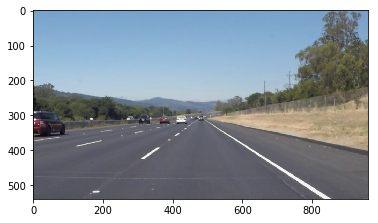

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    '''
    We don't modify the function draw_lines() directly.
    Instead, we write a new function reduce_lines() which 
    reduces lines segegments into single left and right lines.   
    '''
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    It returns `lines` instead of `img`.  
    `lines` is more easy to do post-processed.
        
    Returns list of hough lines.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

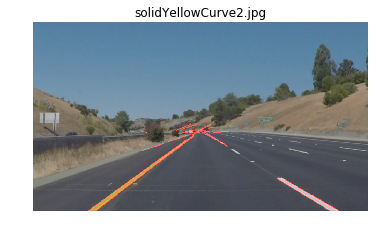

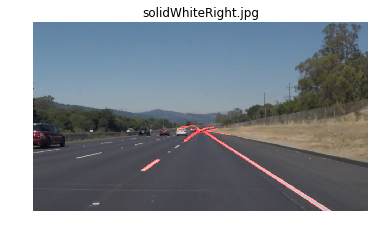

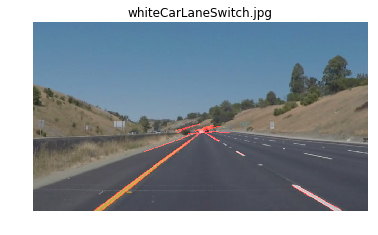

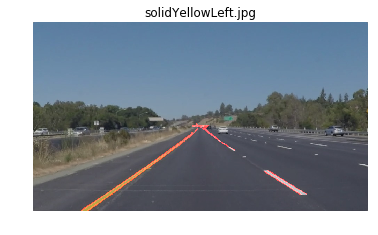

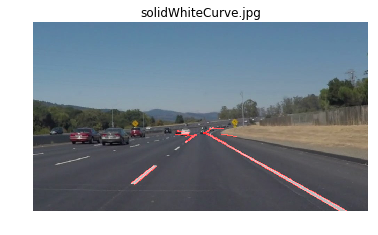

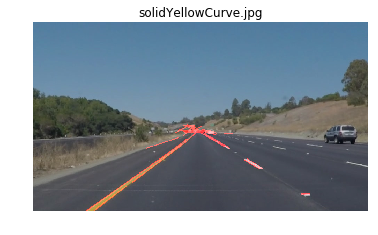

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

# There are our hard coding parameters
GAUS_BLUR = 5
CANNY_LOWER = 50
CANNY_UPPER = 150
MASK_REGIONS = np.array([[(0.55, 0.54), (0.45, 0.54), (0.05, 1.0), (0.95, 1.0)]])  #the vertices ratio of interesting regions
HL_rho = 2              #distance resolution in pixels of the Hough grid
HL_theta = np.pi / 180  #angular resolution in radians of the Hough grid
HL_threshold = 20       #minimum number of votes (intersections in Hough grid cell)
HL_min_line_len = 25    #minimum number of pixels making up a line
HL_max_line_gap = 10    #maximum gap in pixels between connectable line segments

def calc_hough_lines(image):
    if len(image.shape) > 2:
        gray = grayscale(image)
    else:
        gray = image
    gaus = gaussian_blur(gray, GAUS_BLUR)
    edges = canny(gaus, CANNY_LOWER, CANNY_UPPER)
    
    # hard coding interest region
    sx, sy = image.shape[1], image.shape[0]    # note that shape order is permuted
    vertices = (np.array([[(sx, sy)]]) * MASK_REGIONS).astype(int)
    masked = region_of_interest(edges, vertices)
    
    # hard coding edge detection parameters
    lines = hough_lines(masked, HL_rho, HL_theta, HL_threshold, HL_min_line_len, HL_max_line_gap)
    
    return lines

# we define process_image where is also used in the following video processing.
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)   
    lines = calc_hough_lines(image)
    
    line_image = np.zeros(image.shape, dtype=np.uint8)
    draw_lines(line_image, lines, thickness=2)
    result = weighted_img(line_image, image)

    return result

def show_image(image, title):
    plt.figure()
    if len(image.shape)==2:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.title(title)

    
def process_all_images(process_image, indir, outdir):    
    os.makedirs(outdir, exist_ok=True)

    # loop for the images
    images = os.listdir(indir)
    for imgFile in images:
        image = mpimg.imread(indir + imgFile)
        result = process_image(image)
        mpimg.imsave(outdir + imgFile, result)
        show_image(result, imgFile)
            
process_all_images(process_image, "test_images/", "test_images_work/")

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [7]:
video_indir = 'test_videos/'
video_outdir = 'test_videos_work/'
white_output = video_outdir + 'solidWhiteRight.mp4'
clip1 = VideoFileClip(video_indir + "solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_work/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_work/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:02<00:00, 88.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_work/solidWhiteRight.mp4 

CPU times: user 14.4 s, sys: 708 ms, total: 15.1 s
Wall time: 2.69 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

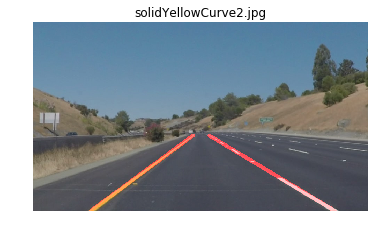

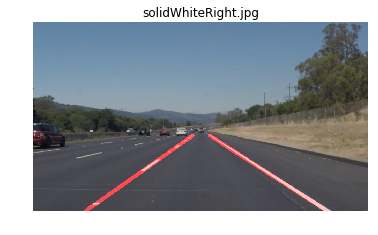

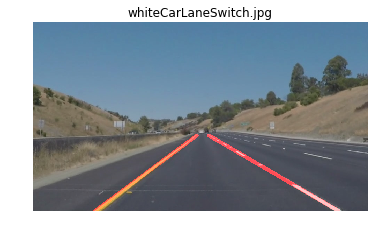

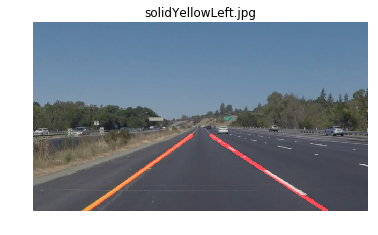

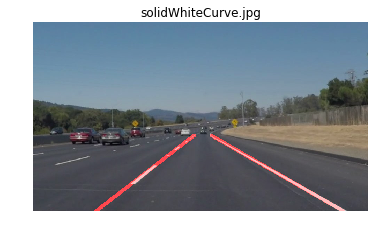

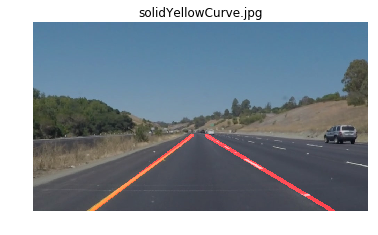

In [9]:
# we don't rewrite draw_lines() function directly
# instead, we post_process hough lines by function reduce_lines().
# reduce_lines() will reduce line segments into left side and right side single lines.

def get_line_parameter(line, sy):
    '''
    We reverse y coordinate to let y=0 be the bottom line of image.
    Then we transfer line segment into a three-parameter tuple
    (x0, theta, line_length) where line segment is 
        y = (x-x0) * tan(theta)

            Y ^ 
              |       * (x2, y2)
              |      /
              |     * (x1, y1)
              |    /
              |   / theta
        (0,0) |------------> X
                (x0,0)
    '''
    
    x1, y1, x2, y2 = line
    
    # reverse y, let y=0 be the bottom line
    y1, y2 = sy - y1, sy - y2
    
    # swap it, y2 alway is larger (near top) then y1 
    if y1 > y2:        
        x1, y1, x2, y2 = x2, y2, x1, y1
    
    dx = x2 - x1
    dy = y2 - y1    
    x0 = x1 - y1 * dx / dy if dy != 0 else 0
    theta = math.atan2(dy, dx)
    line_length = math.sqrt((x2-x1)**2+(y2-y1)**2)
    
    return x0, theta, line_length

def weight_average_lines(lines):
    '''
    We average the line angles intead of coefficients.
    Using the line segment length as its weight.
    '''
    sum_x0 = 0
    sum_theta = 0
    sum_weight = 0
    for x0, theta, weight in lines:
        sum_x0 += x0 * weight
        sum_theta += theta * weight
        sum_weight += weight
        
    if sum_weight > 0:
        sum_x0 = sum_x0 / sum_weight 
        sum_theta = sum_theta / sum_weight 
    return sum_x0, sum_theta    
    
def calc_xcord_from_parameter(x0, theta, y1):
    '''
        y1 = (x1-x0) * tan(theta)
        so, x1 = x0 + y1 / tan(theta)

            Y ^ 
              |      * (x1, y1)
              |     /
              |    /
              |   / theta
        (0,0) |------------> X
                (x0,0)
    '''
    tan = math.tan(theta)
    x1 = x0 + (y1 / tan if tan != 0 else 0)
    return x1
    
def reduce_lines(lines, sx, sy):
    '''
    It return the left and right reduced line from given segments.
    For debug reason, it also returns the line segments after filtered out.
    
    reduce lines steps:
    1. filter out the invalid line segments by given, 
        20 degree < theta < 45 degree and 
        5% * image_wdth < x0 < 30% * image_wdth, for left line segment
        It uses the mirror condition for right line segment
    2. weight average theta and x0 of left and right line segments.

    '''
    
    left_lines = [] 
    right_lines = []
    filtered_lines = []
    
    # hard code valid segment ranges
    left_x0_range = (sx * 0.05, sx * 0.30)
    left_theta_range = (20 * math.pi / 180, 45 * math.pi / 180)
    right_x0_range = (sx - left_x0_range[1], sx - left_x0_range[0])
    right_theta_range = (math.pi - left_theta_range[1], math.pi - left_theta_range[0])
    
    for sub_lines in lines:
        # convert to (x, y) = (x0, sy) + t(cos(theta), sin(theta))
        # each line is represented by a tulip (x0, theta, line_length)
        for line in sub_lines:
            x0, theta, line_length = get_line_parameter(line, sy)
            # filter out left lines
            if x0 > left_x0_range[0] and x0 < left_x0_range[1] and \
               theta > left_theta_range[0] and theta < left_theta_range[1]:
                left_lines.append((x0, theta, line_length))
                filtered_lines.append(line)
                          
            if x0 > right_x0_range[0] and x0 < right_x0_range[1] and \
               theta > right_theta_range[0] and theta < right_theta_range[1]:
                right_lines.append((x0, theta, line_length))
                filtered_lines.append(line)
            
                
    # we average x0 and theta with weight line_length, left and right lines seperately
    left_x0, left_theta = weight_average_lines(left_lines)
    right_x0, right_theta = weight_average_lines(right_lines)
    
    # calc two lines using averaged x0 and theta    
    y1 = 0.40 * sy
    left_x1 = calc_xcord_from_parameter(left_x0, left_theta, y1)
    right_x1 = calc_xcord_from_parameter(right_x0, right_theta, y1)

    left_line = [left_x0, sy, left_x1, sy - y1]
    right_line = [right_x0, sy, right_x1, sy - y1]
    
    return [[left_line], [right_line]], [filtered_lines]

def process_image_using_reduce_lines(image):
    '''
    We define process_image_using_reduce_lines(), which is almost the same as the previous process_image(),
    except adding a new line reduce_lines().
    '''
    lines = calc_hough_lines(image)
    
    # reduce line segments into left side and right side single lines
    lines, _ = reduce_lines(lines, image.shape[1], image.shape[0])
    
    line_image = np.zeros(image.shape, dtype=np.uint8)
    draw_lines(line_image, lines, thickness=10)
    result = weighted_img(line_image, image)

    return result

# we re-run the all six test images
process_all_images(process_image_using_reduce_lines, 'test_images/', 'test_images_output/')

In [10]:
# now we do solidWhiteRight.mp4 case again
video_indir = 'test_videos/'
video_outdir = 'test_videos_output/'
white_output = video_outdir + 'solidWhiteRight.mp4'
clip1 = VideoFileClip(video_indir + "solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image_using_reduce_lines) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:02<00:00, 87.37it/s] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 14.6 s, sys: 680 ms, total: 15.3 s
Wall time: 2.74 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [12]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image_using_reduce_lines)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:07<00:00, 95.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 38.5 s, sys: 2.01 s, total: 40.5 s
Wall time: 7.3 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

## Just Apply the Unmodified Pipeline

We just applied the unmoidied pipeline on the the challenge video at first.  It worked but it seemed there were more lane line shifting.  

In [14]:
# At fisrt, we just apply the same pipeline on the chanllenge case to see what happened.

video_indir = 'test_videos/'
video_outdir = 'test_videos_work/'
challenge_output = video_outdir + 'challenge.mp4'
clip3 = VideoFileClip(video_indir + 'challenge.mp4')
challenge_clip = clip3.fl_image(process_image_using_reduce_lines)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_work/challenge.mp4
[MoviePy] Writing video test_videos_work/challenge.mp4


100%|██████████| 251/251 [00:04<00:00, 51.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_work/challenge.mp4 

CPU times: user 20 s, sys: 1.36 s, total: 21.4 s
Wall time: 5.23 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_outdir + 'challenge.mp4'))

## Analyze the Cause by Captured Images

To analyze the cause, we capture three images at the 3rd, 4th, 5th second for further analysis.  The edge dectection became more difficult because 
1. there are a lot of shadows of trees
2. the road color is not so uniformed
3. the contract of the left yellow land is not so obvious
4. the right land is not always clearly visible.

The first and second causes are not so critical. Most of their edges are filtered out because their orientation. Even they has similar orientation as the lane line, it has a small weight of averaging because of its short length.

The third is critical.  The captured images at 3rd and 5th second cannot almost detect the yellow line edge. The following modified pipeline will try to handle it.

The fourth is not so critical but obviousable.  It may be handle by dynamic threshold to do edge detection.  However, we didn't implement it in our project.

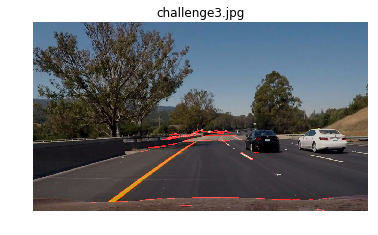

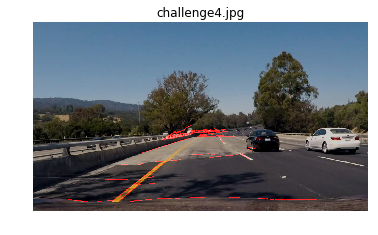

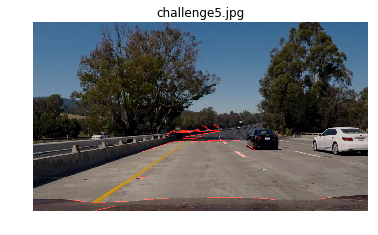

In [16]:
# capture video image at the 3rd, 4th, 5th second. 
video_indir = 'test_videos/'
video_outdir = 'test_videos_work/'
clip3 = VideoFileClip(video_indir + 'challenge.mp4')
    
for t in [3, 4, 5]:
    imgFile = 'challenge{}.jpg'.format(t)
    clip3.save_frame(video_indir + imgFile, t=t)
    
# find lane using the unmodified version    
for t in [3, 4, 5]:
    imgFile = 'challenge{}.jpg'.format(t)
    image = mpimg.imread(video_indir + imgFile)
    result = process_image(image)
    mpimg.imsave(video_outdir + imgFile, result)
    show_image(result, imgFile)

## Modified Pipeline

Because yellow line is different color from the road.  It would be easy to seperate on color space.  So our ad hoc method is convert color image into a hsv image instead a gray image.  Then we do edge detect in H, S, V domain image seperately. All detected edges are the candidates of the reduce_lines() function.

Ideally, we can apply different edge detection parameters for H, S, V domain image seperately.  However, we just use the same parameters for all three domain image for simplicity.

In [17]:
def calc_hsv_hough_lines(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    all_lines = []
    for channel in range(0, 3):
        gray = hsv[:,:,channel]
        gaus = gaussian_blur(gray, 5)
        edges = canny(gaus, 50, 150)
    
        # hard coding interest region
        sx, sy = image.shape[1], image.shape[0]    # note that shape order is permuted
        vertices = np.array([[(sx*0.55, sy*0.54), (sx*0.45, sy*0.54), (sx*0.05, sy), (sx*0.95, sy)]], dtype=np.int32)
        masked = region_of_interest(edges, vertices)
    
        # hard coding edge detection parameters
        rho = 2              #distance resolution in pixels of the Hough grid
        theta = np.pi / 180  #angular resolution in radians of the Hough grid
        threshold = 20       #minimum number of votes (intersections in Hough grid cell)
        min_line_len = 25    #minimum number of pixels making up a line
        max_line_gap = 10    #maximum gap in pixels between connectable line segments
        lines = hough_lines(masked, rho, theta, threshold, min_line_len, max_line_gap)
        all_lines += list(lines)
        
    return all_lines

def calc_hsv_hough_lines2(image):
    imshape = image.shape
    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # White Filter:
    lower_w = np.array([0,0,200])
    upper_w = np.array([180,25,255])

    hsv_w_mask = cv2.inRange(hsv,lower_w, upper_w)

    hsv_w = cv2.bitwise_and(hsv,hsv, mask= hsv_w_mask)

    # Yewllow Filter
    lower_y = np.array([15,75,75])
    upper_y = np.array([35,255,255])

    hsv_y_mask = cv2.inRange(hsv,lower_y, upper_y)

    hsv_y = cv2.bitwise_and(hsv,hsv, mask= hsv_y_mask)
    
    color_masked = cv2.add(hsv_y, hsv_w)

    mean = np.mean(hsv)
    stdev = np.std(hsv)
    canny_low = mean - 0.33*stdev
    canny_high = mean + 0.33*stdev

    edges = canny(color_masked, canny_low, canny_high)  

    # hard coding edge detection parameters
    rho = 2              #distance resolution in pixels of the Hough grid
    theta = np.pi / 180  #angular resolution in radians of the Hough grid
    threshold = 20       #minimum number of votes (intersections in Hough grid cell)
    min_line_len = 25    #minimum number of pixels making up a line
    max_line_gap = 10    #maximum gap in pixels between connectable line segments
    lines = hough_lines(edges, rho, theta, threshold, min_line_len, max_line_gap)
        
    return lines
    
def process_hsv_image(image):
    lines = calc_hsv_hough_lines(image)
    
    # reduce line segments into left side and right side single lines
    lines, _ = reduce_lines(lines, image.shape[1], image.shape[0])
    
    line_image = np.zeros(image.shape, dtype=np.uint8)
    draw_lines(line_image, lines, thickness=10)
    result = weighted_img(line_image, image)

    return result

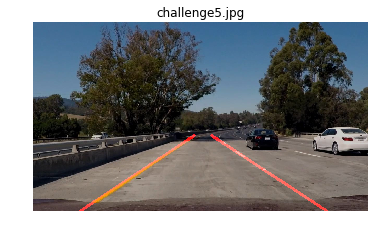

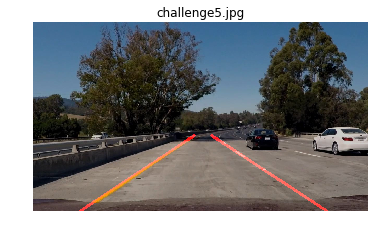

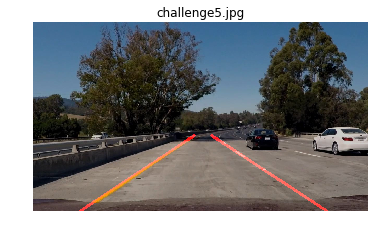

In [18]:
video_indir = 'test_videos/'
video_outdir = 'test_videos_output/'
clip3 = VideoFileClip(video_indir + 'challenge.mp4')
    
# loop for the images
images = os.listdir(video_indir)
for t in range(3,6):
    image = mpimg.imread(video_indir + imgFile)
    result = process_hsv_image(image)
    mpimg.imsave(video_outdir + imgFile, result)
    show_image(result, imgFile)

Finnaly, we apply the modified pipeline on the challenge video

In [19]:
video_indir = 'test_videos/'
video_outdir = 'test_videos_output/'
challenge_output = video_outdir + 'challenge.mp4'
clip3 = VideoFileClip(video_indir + 'challenge.mp4')
challenge_clip = clip3.fl_image(process_hsv_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:13<00:00, 18.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 49.9 s, sys: 3.78 s, total: 53.7 s
Wall time: 13.8 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))